In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import maxabs_scale
from sklearn.metrics import r2_score

from scipy.optimize import nnls, lsq_linear, least_squares
from scipy.interpolate import splev, splrep

%matplotlib inline

In [2]:
# random state
rs = 4

# Data

Gathering and preparation of the data to be inputed into the model.

The countries were selected in the EDA file, populations were taken from https://worldpopulationreview.com/countries.

In [3]:
from lib.data.nations import cc_dict, pop_dict

## Virus

Virus propagation data is obtained from the CSSE at Johns Hopkins University.

In [4]:
from lib.data.cases import jhu_cases, jhu_death, jhu_recov

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (610, 199)
deaths shape: (610, 199)
recoveries shape: (610, 199)


To ensure the smoothness of the data, **rolling average** is applied.

In [5]:
from lib.data.cases import window, cum_cases, cum_deaths, cum_recoveries

Use it to compute further variables (compartments) needed to represent the compartmental model.

In [6]:
R = cum_deaths + cum_recoveries
I = cum_cases - R
S = pop_dict.values() - cum_cases

In [7]:
r_prop = R / pop_dict.values()
i_prop = I / pop_dict.values()
s_prop = S / pop_dict.values()

### Initial approximation

Operate with the proportional compartments; $s, i, r$. Analyse the beginning of the pandemic, assuming $\lim_{t\rightarrow0}s\rightarrow1$. Therefore, study the change of the growth rate $gr=\log{i_2}-\log{i_1}=\beta-\gamma$.

In [8]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i = np.log(i_prop)
warnings.resetwarnings()
# before the pandemic begins, the growth must be zero
log_i[np.isinf(log_i)] = 0

In [9]:
gr = log_i[1:] - log_i[:-1].values # different index

### Transmission coefficient computation

Operate with the relative compartments to save operations. Only assuming independence with time (same as last time), study $\beta=\frac{gr+\gamma}{s}=\frac{(\log{i_2}-\log{i_1})+\gamma}{s}$. An alternative path to the transmission rate is $\beta=\frac{\log{s_1}-\log{s_2}}{i}$. This has the advantage of not having to deal with values $\log0$, which we were classifying as $0$.

Because the SIR model (instead of the SEIR model) is being used, the resulting transmission coefficient will be small.

In [10]:
# dr_dt = r_prop[1:] - r_prop[:-1].values # different index
# gamma = dr_dt / i_prop[1:]
# gamma[np.isinf(gamma)] = np.nan # division by zero
# gamma[gamma.isna()] = 0         # before the pandemic begins
# beta = (gr + gamma) / s_prop[1:]

In [11]:
# the alternative formula
log_s = np.log(S)
diff_log = log_s[:-1].values - log_s[1:] # same index as other variables
beta = diff_log / I

## Policy

We focus on policies aimed at obstructing the spread of the virus. The Oxford group considers four types of measures:

*   Containment
*   Economic
*   Health system
*   Miscellaneous

Here containment and some health system-related measures are considered.

In [12]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
    from lib.data.policies import oxcgrt, oxcgrt_sub

The Oxford dataset contains earlier dates compared to the JHU dataset.

In [13]:
print('Virus data: ', jhu_cases.index.min(), '-', jhu_cases.index.max())
print('Policy data:', oxcgrt['Date'].min(), '-', oxcgrt['Date'].max())

Virus data:  2020-01-22 00:00:00 - 2021-09-22 00:00:00
Policy data: 2020-01-01 00:00:00 - 2022-08-24 00:00:00


After some manipulation, it is possible to obtain a different table per policy type.

In [14]:
from lib.data.policies import CH_X, idch
 
print('\n'.join(idch))

C1_School closing
C2_Workplace closing
C3_Cancel public events
C4_Restrictions on gatherings
C5_Close public transport
C6_Stay at home requirements
C7_Restrictions on internal movement
C8_International travel controls
H1_Public information campaigns
H6_Facial Coverings


# Model

Development of the model(s) and results.

## Auxiliar

In [15]:
# aux vars
from lib.helper import chx_str

ta = gr.index.min()
tb = gr.index.max()

In [16]:
# aux fns
from lib.helper import _get_init_date, _print_model, std_err, nested_list_to_array

def data_from(iso, t0, t1, tr, t_d, y):
  'Select data with location and time constraints.'

  if iso in cc_dict.keys():
    name = cc_dict[iso]
  elif iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  if not t0:
    t0 = _get_init_date(iso)
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  
  if not t1:
    if not tr:
      raise ValueError('Provide end of time range (either t1 or tr).')
    prop_case = cum_cases[name] / pop_dict[iso]
    t1 = prop_case[prop_case < tr/100].index.max()

  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

# to do: specific for each of the two label types
def preprocess(pol_t, y_t):
  'Transform data to feed the model.'
  
  pol_t.fillna(method='pad', inplace=True) # back fill
  pol_t.fillna(value=0, inplace=True)      # if no previous value available
  pol_norm = maxabs_scale(pol_t[1:])       # match vars length at scaling
  y_norm = maxabs_scale(y_t)

  # policy combinations
  # poly = PolynomialFeatures(degree=2, interaction_only=True)
  # pol_comb = poly.fit_transform(pol_norm)
  # comb_str = poly.get_feature_names(chx_str)
  # day-of-the-week
  # day = y_t[1:].index.weekday.values.reshape(-1, 1)
  # ohe = OneHotEncoder(sparse=False).fit_transform(day)
  # ohe_str = [f'weekday {d+1}' for d in range(7)]
  # previous 
  td1 = y_norm[:-1].reshape(-1, 1)
  # group data
  arr = np.hstack([pol_norm, td1])
  col = np.append(chx_str, 'prev')
  df = pd.DataFrame(arr, columns=col)

  # label = pd.Series(y_norm[1:], index=y_t[1:].index) # date ref
  
  return df, y_norm[1:]

def cross_validation(*, data, grid, model, model_api, ccs=cc_dict, t_init=None, t_end=None, **kwargs):
  'Cross-validation across different countries and librares.'
  
  cv_arr = []
  for cc in ccs:
    cv_cc = []
    for par in list(ParameterGrid(grid)):
      if len(par) == 1:
        X_raw, y_raw = data_from(cc, t_init, t_end, None, par['delay'], data)
      else:
        X_raw, y_raw = data_from(cc, t_init, t_end, par['tr'], par['delay'], data)
      X, y = preprocess(X_raw, y_raw)
      kf = KFold(shuffle=True, random_state=rs)
      cv_kf = []
      # different notation for different models
      for train_idx, test_idx in kf.split(X):
        if model_api == 'sklearn':
          fit = model.fit(X.iloc[train_idx], y[train_idx])
          kf_score = fit.score(X.iloc[test_idx], y[test_idx])
        else: # scipy api
          if model_api == 'nnls':   # non-negative least squares
            fit = model(X.iloc[train_idx], y[train_idx])[0]
          elif model_api == 'lls':  # linear least squares
            fit = model(X.iloc[train_idx], y[train_idx], kwargs['bounds'])['x']
          elif model_api == 'nlls': # non-linear least squares
            # to do: use the last output of the function (success flag)
            # if(success == False): raise Exception
            fit = model(
                kwargs['fun'], kwargs['x0'], bounds=kwargs['bounds'], 
                args=(X.iloc[train_idx], y[train_idx])
            )['x']
          kf_score = r2_score(y[test_idx], X.iloc[test_idx] @ fit) 
        cv_kf.append(kf_score)
        # to do: filter negative values
        score = np.asarray(cv_kf).mean()
      cv_cc.append(score)
    cv_arr.append(cv_cc)
  cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
  return cv_arr

In [17]:
# plot fns
from img.plt import heatmap

## Initial model

Uses the groth rate, $gr=\beta-\gamma$, as label. Conditioned on the restriction $s\rightarrow1$, it reaches a different time range depending on the country.

Customized grid of values for the parameters.

Compare the linear regression and Lasso stability of coefficients.

The LARS implementation of Lasso is much faster and it was used for the CV loop. However, the number of regressors needs to be restricted due to convergency issues and the general accuracy obtained is lower compared to the standard *brute force* Lasso. Therefore, the LARS implementation it is not used anymore.

Using cross-validation on all available data, can yield sizeable negative values (sometimes) while performing least squares. Filter those values or assign value zero.

In [18]:
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}

In [19]:
cv_arr = cross_validation(data=gr, 
                          grid=grid, 
                          model=LinearRegression(),
                          model_api='sklearn')
cv_arr

array([-5.75818558e+24,  8.87445078e-01, -1.23068489e+26, -1.07103125e+25,
        8.22156598e-01, -1.16715281e+25,  8.80397772e-01,  8.48524859e-01,
        8.61893500e-01,  8.20298308e-01, -4.65754188e+23, -2.52333589e+24,
       -2.50553075e+24,  8.72128234e-01,  8.24093629e-01, -7.42690840e+24,
       -8.28025011e+23,  8.48690708e-01,  8.72819172e-01,  8.27995572e-01,
       -1.30030910e+24, -8.81755581e+24, -6.02927344e+23,  8.73539734e-01,
       -2.39473059e+22])

In [20]:
cv_arr.mean()

-7.028112362878924e+24

In [21]:
cv_arr = cross_validation(data=gr,
                          grid=grid,
                          model=LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4),
                          model_api='sklearn')
cv_arr

array([0.90366387, 0.87113832, 0.83547819, 0.85229702, 0.8200954 ,
       0.9094991 , 0.87846396, 0.83971849, 0.85437053, 0.8183811 ,
       0.90683201, 0.87614637, 0.83212721, 0.85285116, 0.81770612,
       0.90903311, 0.87986583, 0.8332023 , 0.85368301, 0.81766425,
       0.91015115, 0.87958634, 0.83481992, 0.85431485, 0.8202987 ])

In [22]:
cv_arr.mean()

0.8584555322861505

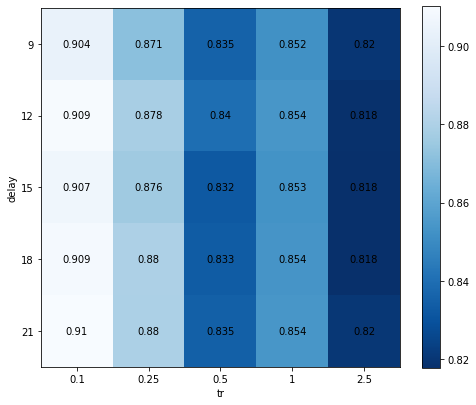

In [23]:
cv_mat = cv_arr.reshape(5, 5)

fig, ax = heatmap(cv_mat, xticks=grid['tr'], yticks=grid['delay'], cmap="Blues_r")
ax.set(xlabel="tr", ylabel="delay")
fig.tight_layout()

In [24]:
def initial_model(region, tr=1, delay=15, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, None, None, tr, delay, gr)
  X, y = preprocess(X_raw, y_raw)
  coef_names = X.columns.values
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=rs
  )

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  lasso.fit(X_train, y_train)
  score = lasso.score(X_test, y_test)

  reg = Lasso(alpha=lasso.alpha_).fit(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

In [25]:
coef, r_sq = [], []
for k in cc_dict.keys():
  m_k, X_k, y_k, r_k = initial_model(k)
  coef.append(m_k.coef_[:-1])
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameteres.

In [26]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.7893270689443389 0.11064928157898217


In [27]:
for r_i in r_sq:
  print(round(r_i, 2), end='\t')

0.78	0.93	0.97	0.98	0.37	0.9	0.96	0.97	0.89	-0.26	0.97	0.97	0.66	0.96	

Global effect of each policy.

In [28]:
coef = np.asarray(coef)
mu_coef = coef.mean(axis=0)
for string, value in zip(idch, mu_coef):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.012153
Workplace closing                 -> -0.002214
Cancel public events              -> -0.016052
Restrictions on gatherings        -> -0.017851
Close public transport            -> 0.000916
Stay at home requirements         -> 0.001537
Restrictions on internal movement -> -0.002380
International travel controls     -> 0.001251
Public information campaigns      -> -0.022518
Facial Coverings                  -> -0.007803


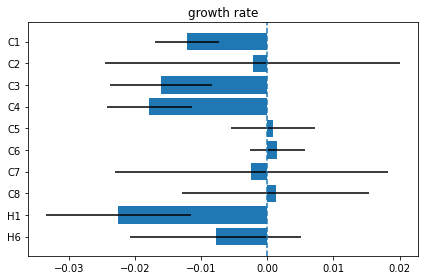

In [29]:
err_coef = std_err(coef)

plt.barh(chx_str[::-1], mu_coef[::-1], xerr=err_coef) # flip order of the coefficients
plt.axvline(ls='--')
plt.title("growth rate")
plt.tight_layout()

In [30]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Textual representation of the model for one country.

In [31]:
idx = -1 # country index
cci = list(cc_dict.keys())[idx]
initial_model(cci, print=True)

Coefficients
------------
C1 : -0.087002
C2 : -0.001749
C4 : -0.067837
C5 : -0.011401
C6 : -0.007973
C8 : -0.009861
H1 : -0.005950
H6 : -0.030901
prev : 0.689363

R^2
---
0.961


Visual representation of the model.

Number of data points: 134
Number of variables: 11


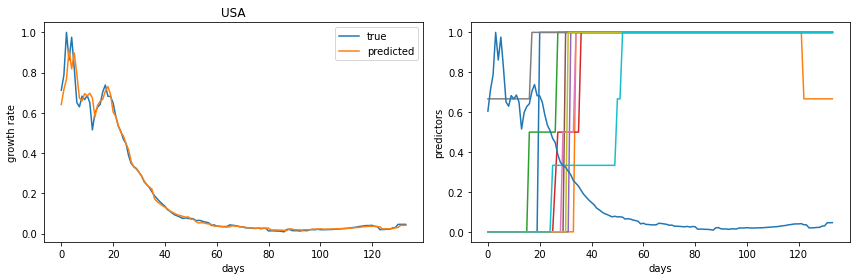

In [32]:
model, X, y = initial_model(cci)[:3]

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(y, label='true')
axs[0].plot(model.predict(X), label='predicted')
axs[0].set(xlabel="days", ylabel="growth rate", title=cci)
axs[0].legend()
X.plot(ax=axs[1], legend=False)
axs[1].set(xlabel="days", ylabel="predictors")
fig.tight_layout()

print('Number of data points:', X.shape[0])
print('Number of variables:', X.shape[1])

## Transmission model

It uses the transmission rate, $\beta$, as label. The linear function is fitted in thiner time segments.

Parameter grid search.

In [33]:
grid = {'delay': range(1, 21)}
# mm-dd-yyyy format
t_init = pd.to_datetime('06-01-2020')
t_end = t_init + pd.to_timedelta(60, unit='days')

In [34]:
cv_arr = cross_validation(data=beta,
                          grid=grid,
                          model=LinearRegression(),
                          model_api='sklearn',
                          t_init=t_init,
                          t_end=t_end)
cv_arr

array([ 9.14736566e-01,  9.20145065e-01,  9.17115380e-01, -2.42661496e+21,
        9.21066501e-01,  9.20096881e-01,  9.16144516e-01,  9.16355040e-01,
        9.18647569e-01,  9.20197462e-01, -1.14798268e+20,  9.15307231e-01,
        9.18043697e-01,  9.19815221e-01,  9.15305663e-01,  9.17929169e-01,
        9.18505475e-01,  9.19856914e-01,  9.18744179e-01,  9.18822381e-01])

In [35]:
cv_arr.mean()

-1.2707066164043537e+20

In [36]:
cv_arr = cross_validation(data=beta,
                          grid=grid,
                          model=LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4),
                          model_api='sklearn',
                          t_init=t_init,
                          t_end=t_end)
cv_arr

array([0.91574452, 0.91765301, 0.91632034, 0.91475021, 0.92009798,
       0.9191252 , 0.91675248, 0.91646194, 0.918881  , 0.91912383,
       0.91871025, 0.9169556 , 0.91654277, 0.91723246, 0.91403654,
       0.91482599, 0.91747937, 0.92014291, 0.91927338, 0.91877228])

In [37]:
cv_arr.mean()

0.9174441027905562

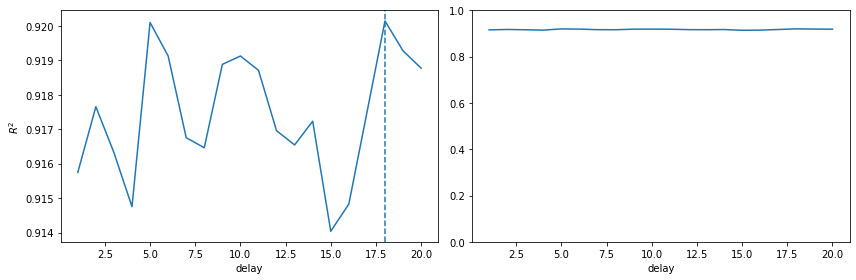

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid['delay'], cv_arr)
axs[0].axvline(grid['delay'][cv_arr.argmax()], ls='--')
axs[0].set(xlabel="delay", ylabel="$R^2$")
axs[1].plot(grid['delay'], cv_arr, scaley=False)
axs[1].set_xlabel("delay")
fig.tight_layout()

In [39]:
def linear_model(region, delay=12, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X, y, reg, score, coef_values = [], [], [], [], []
  # apply the model to each subrange
  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    lasso.fit(X_train, y_train)
    score_i = lasso.score(X_test, y_test)

    reg_i = Lasso(alpha=lasso.alpha_).fit(X_i, y_i)
    coef_values_i = reg_i.coef_
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    reg.append(reg_i)
    coef_values.append(coef_values_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef_values).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

In [40]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  m_k, X_k, y_k, r_k = linear_model(k)
  # each model is defined in segments (invervals)
  coef_k = [lasso.coef_[:-1] for lasso in m_k]
  coef_glob.append(np.asarray(coef_k).mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))                    # individual
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameters. Is computed from the testing set.

In [41]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9167164702901888 0.004662504254465433


In [42]:
for r_i in r_sq:
  print(round(r_i, 2), end='\t')

0.87	0.95	0.86	0.93	0.98	0.96	0.76	0.94	0.93	0.96	0.98	0.97	0.78	0.97	

*Global* values for the coefficients of each policy type.

In [43]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
for string, value in zip(idch, mu_coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.001711
Workplace closing                 -> -0.000890
Cancel public events              -> -0.001917
Restrictions on gatherings        -> -0.005418
Close public transport            -> -0.002230
Stay at home requirements         -> -0.004698
Restrictions on internal movement -> 0.002939
International travel controls     -> -0.002128
Public information campaigns      -> -0.000696
Facial Coverings                  -> -0.002250


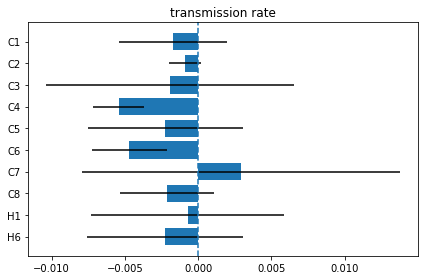

In [44]:
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order of the coefficients
plt.axvline(ls='--')
plt.title("transmission rate")
plt.tight_layout()

*Interval*-wise values for the coefficients of each policy type. They are meant to represent the coefficients at different stages of the pandemic.

In [45]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
coef_intv = nested_list_to_array(coef_intv, len(chx_str))
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 8, 10)
(8, 10)


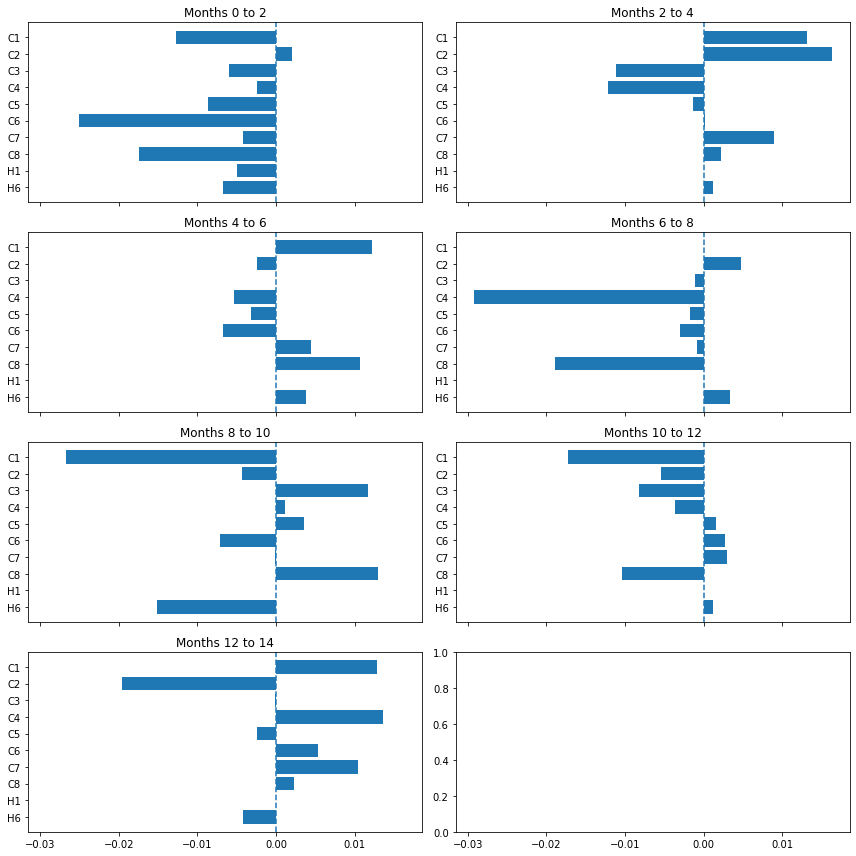

In [46]:
fig, axs = plt.subplots(nrows=coef_intv.shape[0]//2, ncols=2, sharex=True, figsize=(12, 12))
# don't use the last interval with less samples
for n, intv in enumerate(coef_intv[:-1]):
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Months {} to {}'.format(n*2, (n+1)*2))
fig.tight_layout()

In [47]:
size_ratio = 1.25

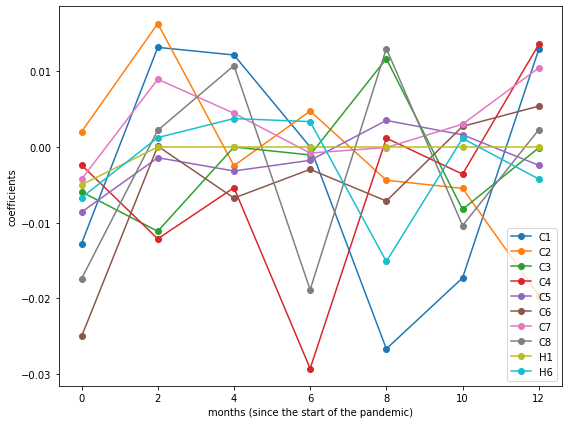

In [48]:
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, coef_intv.shape[0] * 2, 2), coef_intv, 'o-')
plt.xlabel("months (since the start of the pandemic)")
plt.ylabel("coefficients")
plt.legend(chx_str)
plt.tight_layout()

In [49]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Textual representation of single country model.

In [50]:
idx = -2 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

Coefficients
------------
C1 : 0.010216
C2 : -0.005690
C3 : -0.018863
C4 : -0.005812
C5 : 0.004862
C6 : 0.006195
C7 : 0.009143
C8 : 0.000182
H1 : -0.001590
prev : 0.855825

R^2
---
0.784


Resulting predictions of the model.

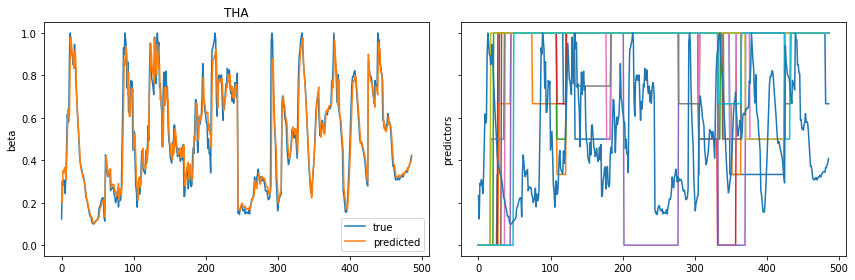

In [51]:
models, Xs, ys = linear_model(cci)[:3]

preds = []
for model, X, y in zip(models, Xs, ys):
  pred_i = model.predict(X)
  preds.append(pred_i)

# array format
X = np.vstack(Xs)
y = np.concatenate(ys)
pred = np.concatenate(preds)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
axs[0].plot(y, label='true')
axs[0].plot(pred, label='predicted')
axs[0].set(ylabel="beta", title=cci)
axs[0].legend()
axs[1].plot(X)
axs[1].set_ylabel("predictors")
fig.tight_layout()

## Constrained model

Uses the transmission rate, $\beta$, as label. The coefficients (in every segment) are forced to take negative values.

### Non-negative least squares

This is achieved by reversing the sign of the coefficients, $\theta$, and imposing a positive constrain, namely $\theta \ge 0$.

Parameter grid search.

In [52]:
cv_arr = cross_validation(data=-beta,
                          grid=grid,
                          model=nnls,
                          model_api='nnls',
                          t_init=t_init,
                          t_end=t_end)
cv_arr

array([0.91531482, 0.91522624, 0.91519392, 0.91529868, 0.91535305,
       0.91541655, 0.91516329, 0.91505907, 0.91502942, 0.91483432,
       0.91483894, 0.91483563, 0.91479546, 0.91475962, 0.91485323,
       0.91472395, 0.91490665, 0.91515123, 0.91522937, 0.91556748])

In [53]:
cv_arr.mean()

0.9150775465344037

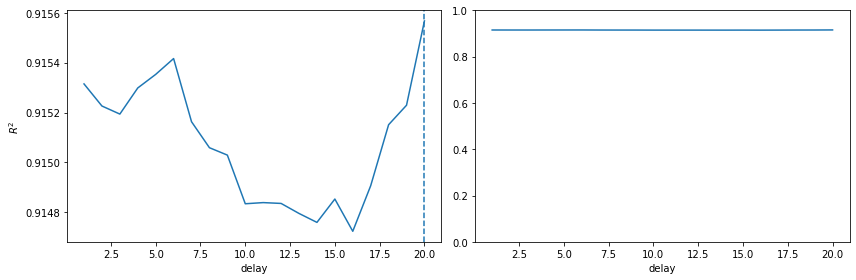

In [54]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid['delay'], cv_arr)
axs[0].axvline(grid['delay'][cv_arr.argmax()], ls='--')
axs[0].set(xlabel="delay", ylabel="$R^2$")
axs[1].plot(grid['delay'], cv_arr, scaley=False)
axs[1].set_xlabel("delay")
fig.tight_layout()

In [55]:
def nnls_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X, y, score, coef = [], [], [], []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, -beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = nnls(X_train, y_train)[0]

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [56]:
coef_glob, coef_intv , r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = nnls_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameters. Is computed from the testing set.

In [57]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9073883796190729 0.005879594541369261


In [58]:
for r_i in r_sq:
  print(round(r_i, 2), end='\t')

0.87	0.93	0.83	0.93	0.97	0.95	0.73	0.95	0.91	0.95	0.98	0.97	0.76	0.96	

*Global* values for the coefficients of each policy type.

In [59]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
for string, value in zip(idch, mu_coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> 0.001699
Workplace closing                 -> 0.003603
Cancel public events              -> 0.000657
Restrictions on gatherings        -> 0.002007
Close public transport            -> 0.000823
Stay at home requirements         -> 0.001532
Restrictions on internal movement -> 0.000969
International travel controls     -> 0.000878
Public information campaigns      -> 0.000171
Facial Coverings                  -> 0.000404


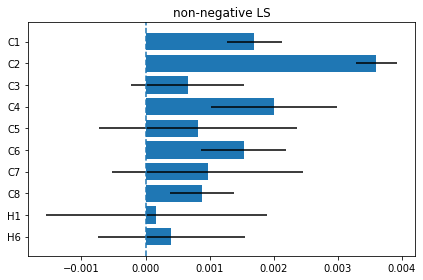

In [60]:
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order of the coefficients
plt.axvline(ls='--')
plt.title("non-negative LS")
plt.tight_layout()

### Linear least-squares with bounds

This optimization problem is convex, hence a found **minimum** (if iterations have converged) is guaranteed to be **global**.

In [61]:
# bound policy coefficients (only)
bounds = (-np.inf, [0] * len(chx_str) + [np.inf])

In [62]:
cv_arr = cross_validation(data=beta,
                          grid=grid,
                          model=lsq_linear,
                          model_api='lls',
                          t_init=t_init,
                          t_end=t_end,
                          bounds=bounds)
cv_arr

array([ 9.14805972e-01,  9.14872584e-01,  9.15193783e-01,  9.15298675e-01,
        9.15027638e-01,  9.15416542e-01,  9.15163290e-01,  9.14904265e-01,
       -1.16318173e+18,  9.14837309e-01,  9.14838706e-01,  9.14835638e-01,
        9.14796920e-01,  9.14759949e-01,  9.14853232e-01,  9.14725488e-01,
        9.14906644e-01,  9.15039532e-01,  9.15231768e-01,  9.14986972e-01])

In [63]:
cv_arr.mean()

-5.8159086491564184e+16

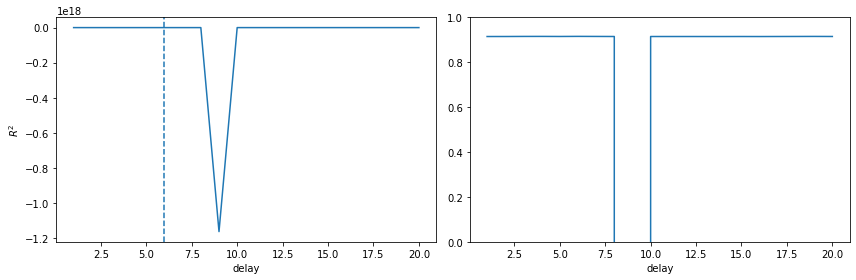

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid['delay'], cv_arr)
axs[0].axvline(grid['delay'][cv_arr.argmax()], ls='--')
axs[0].set(xlabel="delay", ylabel="$R^2$")
axs[1].plot(grid['delay'], cv_arr, scaley=False)
axs[1].set_xlabel("delay")
fig.tight_layout()

In [65]:
def lsq_linear_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X, y, score, coef = [], [], [], []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = lsq_linear(X_train, y_train, bounds=bounds)['x']

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [66]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = lsq_linear_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [67]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9073992224045871 0.005880919183869991


In [68]:
for r_i in r_sq:
  print(round(r_i, 2), end='\t')

0.87	0.93	0.83	0.93	0.97	0.95	0.73	0.95	0.91	0.95	0.98	0.97	0.76	0.96	

In [69]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
for string, value in zip(idch, mu_coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.002902
Workplace closing                 -> -0.002459
Cancel public events              -> -0.001505
Restrictions on gatherings        -> -0.006210
Close public transport            -> -0.025858
Stay at home requirements         -> -0.008823
Restrictions on internal movement -> -0.011420
International travel controls     -> -0.001121
Public information campaigns      -> -0.000507
Facial Coverings                  -> -0.010866


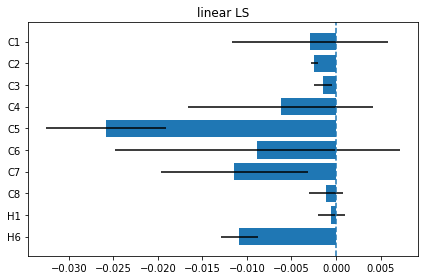

In [70]:
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order of the coefficients
plt.axvline(ls='--')
plt.title("linear LS")
plt.tight_layout()

### Non-linear least-squares with bounds

Given the residuals `fun(x)` (an m-D real function of n real variables) and the (optional) loss function `rho(s)` (a scalar function), `least_squares` finds a **local minimum** of the cost function.

In [71]:
# initial guess on independent variables
x0 = [0] * len(chx_str) + [1]
# computes the vector of residuals
def fun(x, A, y):
  return A @ x - y

In [72]:
cv_arr = cross_validation(data=beta,
                          grid=grid,
                          model=least_squares,
                          model_api='nlls',
                          t_init=t_init,
                          t_end=t_end,
                          fun=fun, x0=x0, bounds=bounds)
cv_arr

array([ 0.65891591, -1.70510568,  0.91519399,  0.91529877,  0.89522283,
        0.91541645,  0.9151636 ,  0.91506023,  0.91174383,  0.91483468,
        0.9148393 ,  0.91483641,  0.91479715,  0.91475982,  0.91485357,
        0.91472441,  0.9149067 ,  0.91506969,  0.91522062,  0.04534216])

In [73]:
cv_arr.mean()

0.7265547218233347

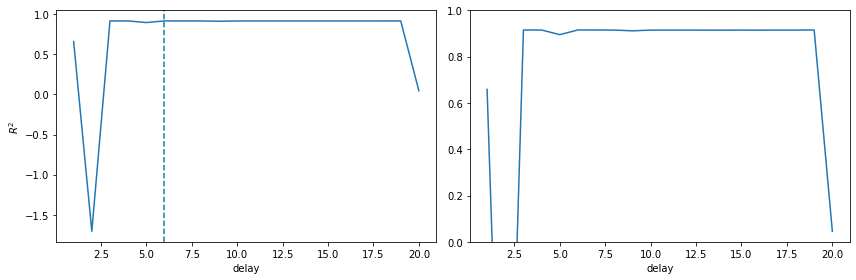

In [74]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid['delay'], cv_arr)
axs[0].axvline(grid['delay'][cv_arr.argmax()], ls='--')
axs[0].set(xlabel="delay", ylabel="$R^2$")
axs[1].plot(grid['delay'], cv_arr, scaley=False)
axs[1].set_xlabel("delay")
fig.tight_layout()

In [75]:
def least_squares_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X, y, score, coef = [], [], [], []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = least_squares(fun, x0, bounds=bounds, args=(X_train, y_train))['x']

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [76]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = least_squares_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [77]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9073891203869705 0.005879727836049218


In [78]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
for string, value in zip(idch, mu_coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.002155
Workplace closing                 -> -0.002503
Cancel public events              -> -0.051350
Restrictions on gatherings        -> -0.074502
Close public transport            -> -1.729679
Stay at home requirements         -> -0.189533
Restrictions on internal movement -> -0.563803
International travel controls     -> -0.001110
Public information campaigns      -> -0.000469
Facial Coverings                  -> -0.022915


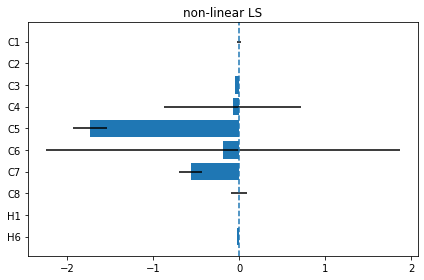

In [79]:
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order of the coefficients
plt.axvline(ls='--')
plt.title("non-linear LS")
plt.tight_layout()

### Final constrained model

The linear least squares model makes use of the linear nature of the problem and gives a global solution without relying on a specific starting point, which proved to give skewed results (a lot of zero-valued coefficients). At the same time, the possibility of applying bounds makes it very flexible and allows to impose the constraints we are looking for ($\theta\le0$).

In [80]:
def constrained_model(region, delay=12, print=False, label=beta):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X, y, score, coef = [], [], [], []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, label)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = lsq_linear(X_train, y_train, bounds=bounds)['x']

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [81]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [82]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9073992224045871 0.005880919183869991


In [83]:
for r_i in r_sq:
  print(round(r_i, 2), end='\t')

0.87	0.93	0.83	0.93	0.97	0.95	0.73	0.95	0.91	0.95	0.98	0.97	0.76	0.96	

In [84]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
for string, value in zip(idch, mu_coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.002902
Workplace closing                 -> -0.002459
Cancel public events              -> -0.001505
Restrictions on gatherings        -> -0.006210
Close public transport            -> -0.025858
Stay at home requirements         -> -0.008823
Restrictions on internal movement -> -0.011420
International travel controls     -> -0.001121
Public information campaigns      -> -0.000507
Facial Coverings                  -> -0.010866


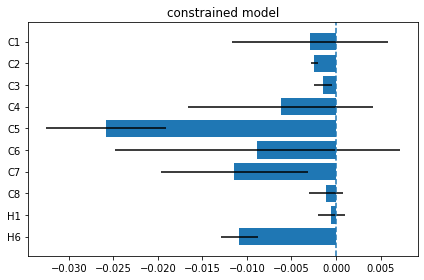

In [85]:
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order of the coefficients
plt.axvline(ls='--')
plt.title("constrained model")
plt.tight_layout()

In [86]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
coef_intv = nested_list_to_array(coef_intv, len(chx_str))
print(coef_intv.shape)
mu_coef_intv = coef_intv.mean(axis=0)
print(mu_coef_intv.shape)

(14, 8, 10)
(8, 10)


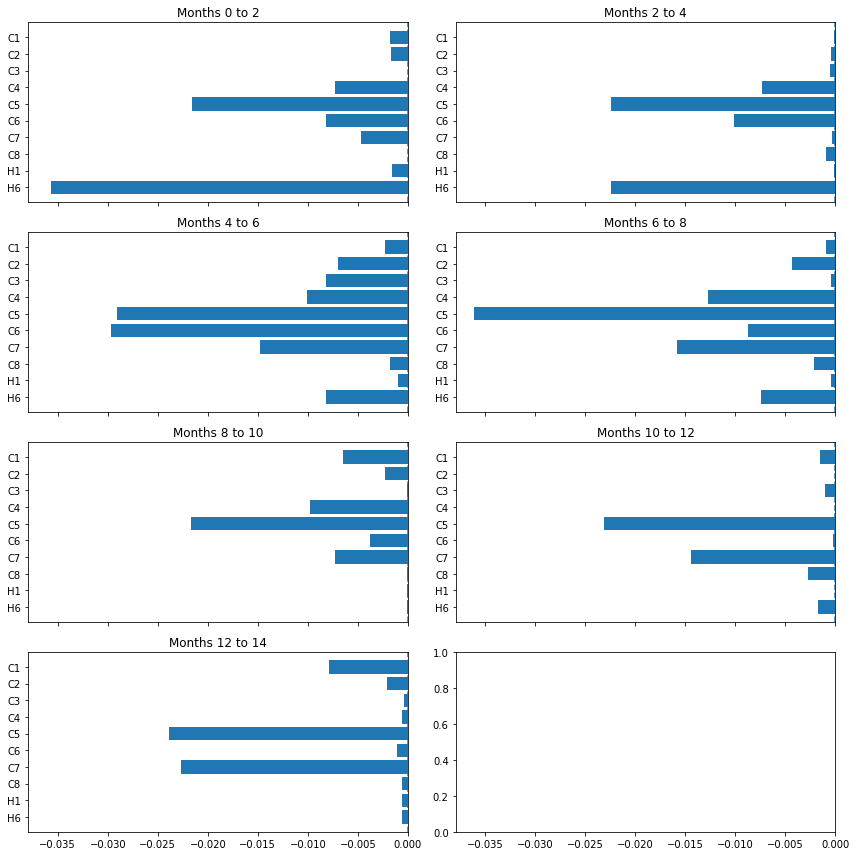

In [87]:
fig, axs = plt.subplots(nrows=coef_intv.shape[1]//2, ncols=2, sharex=True, figsize=(12, 12))
# don't use the last interval with less samples
for n, intv in enumerate(mu_coef_intv[:-1]):
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Months {} to {}'.format(n*2, (n+1)*2))
fig.tight_layout()

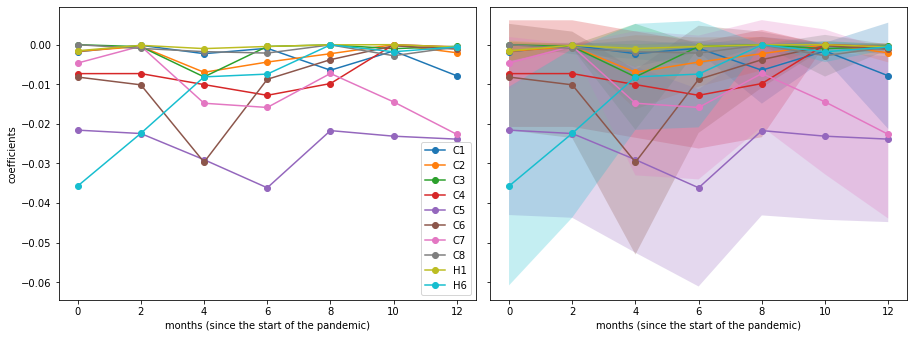

In [88]:
x = range(0, coef_intv.shape[1] * 2, 2)
err = std_err(coef_intv)

size_ratio = 1
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=[6.4*2*size_ratio, 4.8*size_ratio])
axs[0].plot(x, mu_coef_intv, 'o-')
axs[0].set(xlabel="months (since the start of the pandemic)", ylabel="coefficients")
axs[0].legend(chx_str)
axs[1].plot(x, mu_coef_intv, 'o-')
axs[1].set_xlabel('months (since the start of the pandemic)')
for i in range(mu_coef_intv.shape[1]):
  lberr = mu_coef_intv[:, i] - err[:, i]
  hberr = mu_coef_intv[:, i] + err[:, i]
  axs[1].fill_between(x, lberr, hberr, alpha=0.25)
fig.tight_layout()

In [89]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


In [90]:
idx = -2 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

Coefficients
------------
C1 : 0.010216
C2 : -0.005690
C3 : -0.018863
C4 : -0.005812
C5 : 0.004862
C6 : 0.006195
C7 : 0.009143
C8 : 0.000182
H1 : -0.001590
prev : 0.855825

R^2
---
0.784


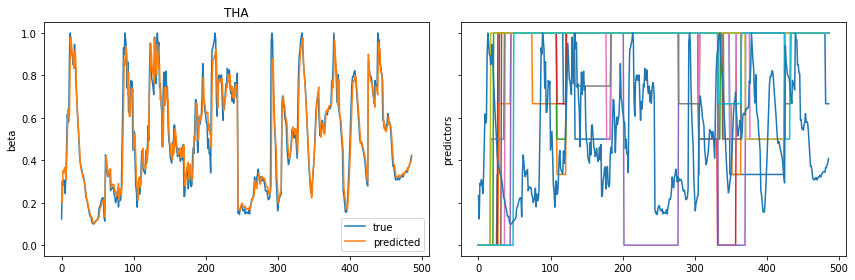

In [91]:
models, Xs, ys = linear_model(cci)[:3]

preds = []
for model, X, y in zip(models, Xs, ys):
  pred_i = model.predict(X)
  preds.append(pred_i)

# array format
X = np.vstack(Xs)
y = np.concatenate(ys)
pred = np.concatenate(preds)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
axs[0].plot(y, label='true')
axs[0].plot(pred, label='predicted')
axs[0].set(ylabel="beta", title=cci)
axs[0].legend()
axs[1].plot(X)
axs[1].set_ylabel("predictors")
fig.tight_layout()

### Alternative beta definitions

The value of $β$ is not supposed to change rapidly over time (**remember the meaning of $\beta$ in this model!**).
Two different strategies to assess the (moderate) changes in $\beta$ are:

* Smoothing $\beta$ over long periods of time (over a week).
* Computing piece-wise linear (B-splines) or piece-wise constant curves for $\beta$.



#### Smoothing

In [92]:
beta_smooth = beta.rolling(window=10, min_periods=1).mean()

In [93]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k, label=beta_smooth)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [94]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9806263733504322 0.00011572189379085783


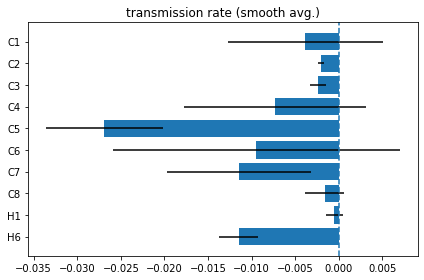

In [95]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order of the coefficients
plt.axvline(ls='--')
plt.title("transmission rate (smooth avg.)")
plt.tight_layout()

In [96]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
coef_intv = nested_list_to_array(coef_intv, len(chx_str))
print(coef_intv.shape)
mu_coef_intv = coef_intv.mean(axis=0)
print(mu_coef_intv.shape)

(14, 8, 10)
(8, 10)


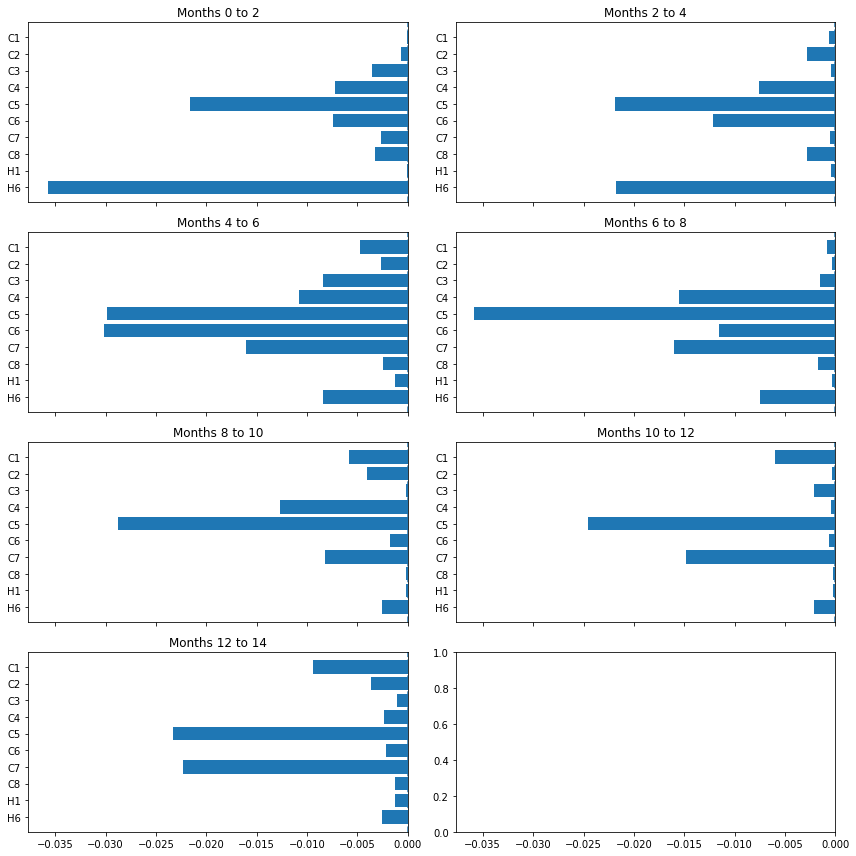

In [97]:
fig, axs = plt.subplots(nrows=coef_intv.shape[1]//2, ncols=2, sharex=True, figsize=(12, 12))
# don't use the last interval with less samples
for n, intv in enumerate(mu_coef_intv[:-1]):
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Months {} to {}'.format(n*2, (n+1)*2))
fig.tight_layout()

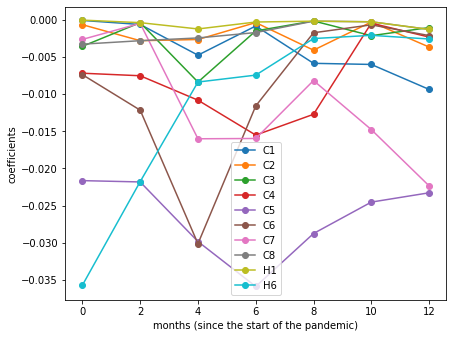

In [98]:
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, coef_intv.shape[1] * 2, 2), mu_coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.tight_layout()

#### Piece-wise constant

In [99]:
beta_rs = beta.resample('1M', label='left').mean()
beta_cst = beta_rs.resample('1d').ffill()
beta_cst = beta_cst[ta:tb] # upsampling expands the date range

In [100]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k, label=beta_cst)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [101]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

-11.489079144683378 1463.2617060757836


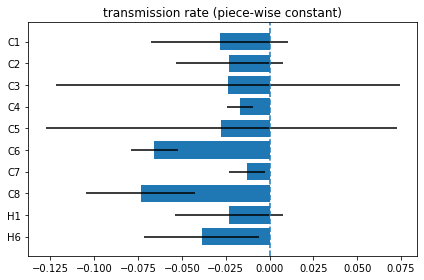

In [102]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order of the coefficients
plt.axvline(ls='--')
plt.title("transmission rate (piece-wise constant)")
plt.tight_layout()

In [103]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
coef_intv = nested_list_to_array(coef_intv, len(chx_str))
print(coef_intv.shape)
mu_coef_intv = coef_intv.mean(axis=0)
print(mu_coef_intv.shape)

(14, 8, 10)
(8, 10)


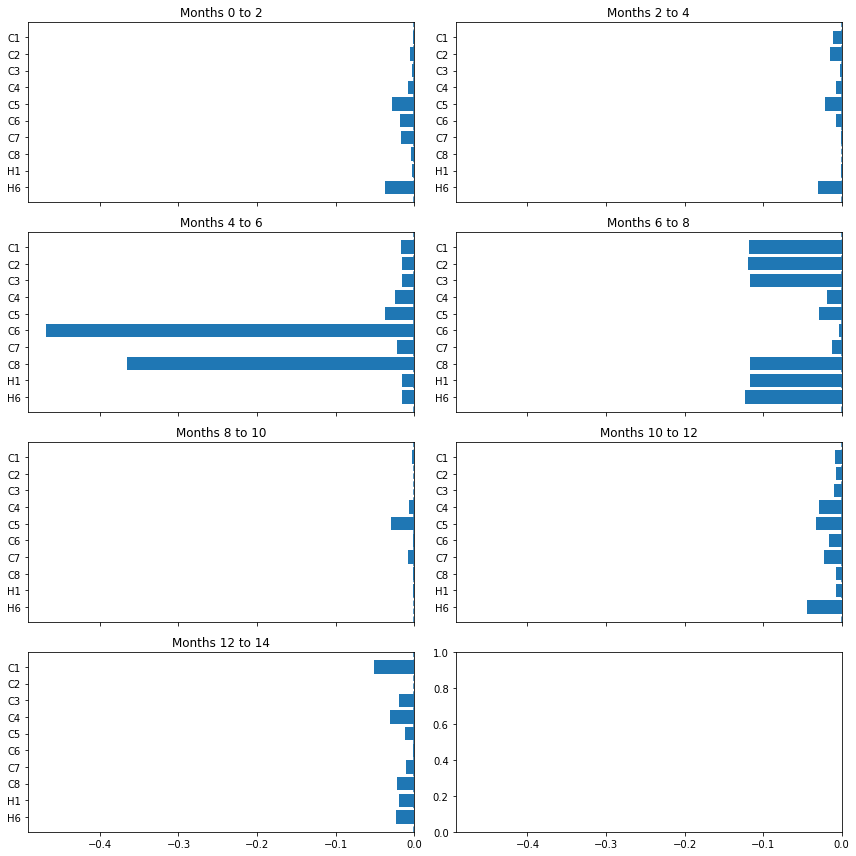

In [104]:
fig, axs = plt.subplots(nrows=coef_intv.shape[1]//2, ncols=2, sharex=True, figsize=(12, 12))
# don't use the last interval with less samples
for n, intv in enumerate(mu_coef_intv[:-1]):
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Months {} to {}'.format(n*2, (n+1)*2))
fig.tight_layout()

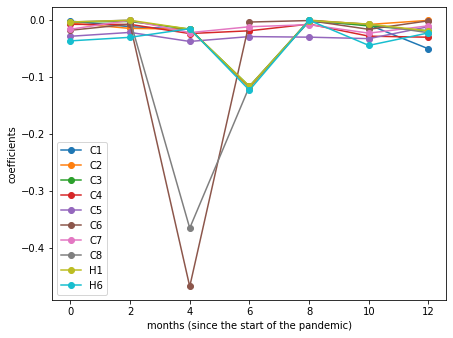

In [105]:
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, coef_intv.shape[1] * 2, 2), mu_coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.tight_layout()

#### Cubic splines

In [106]:
beta_spl = beta.copy()

for cn in cc_dict.values():
  x = range(beta.shape[0])
  y = beta_rs[cn]
  y[y.isna()] = 0
  knots = np.asarray(range(len(y))) * 30

  spl = splrep(knots, y)       # representation
  beta_spl[cn] = splev(x, spl) # evaluation

In [107]:
coef_glob, coef_intv, r_sq = [], [], []
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k, label=beta_spl)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [108]:
print(np.asarray(r_sq).mean(), np.asarray(r_sq).var())

0.9947658017808775 2.157090303369551e-05


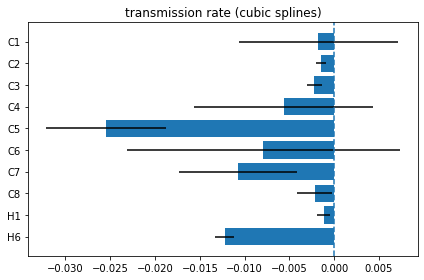

In [109]:
coef_glob = np.asarray(coef_glob)
mu_coef_glob = coef_glob.mean(axis=0)
err_coef = std_err(coef_glob)

plt.barh(chx_str[::-1], mu_coef_glob[::-1], xerr=err_coef) # flip order of the coefficients
plt.axvline(ls='--')
plt.title("transmission rate (cubic splines)")
plt.tight_layout()

In [110]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
coef_intv = nested_list_to_array(coef_intv, len(chx_str))
print(coef_intv.shape)
mu_coef_intv = coef_intv.mean(axis=0)
print(mu_coef_intv.shape)

(14, 8, 10)
(8, 10)


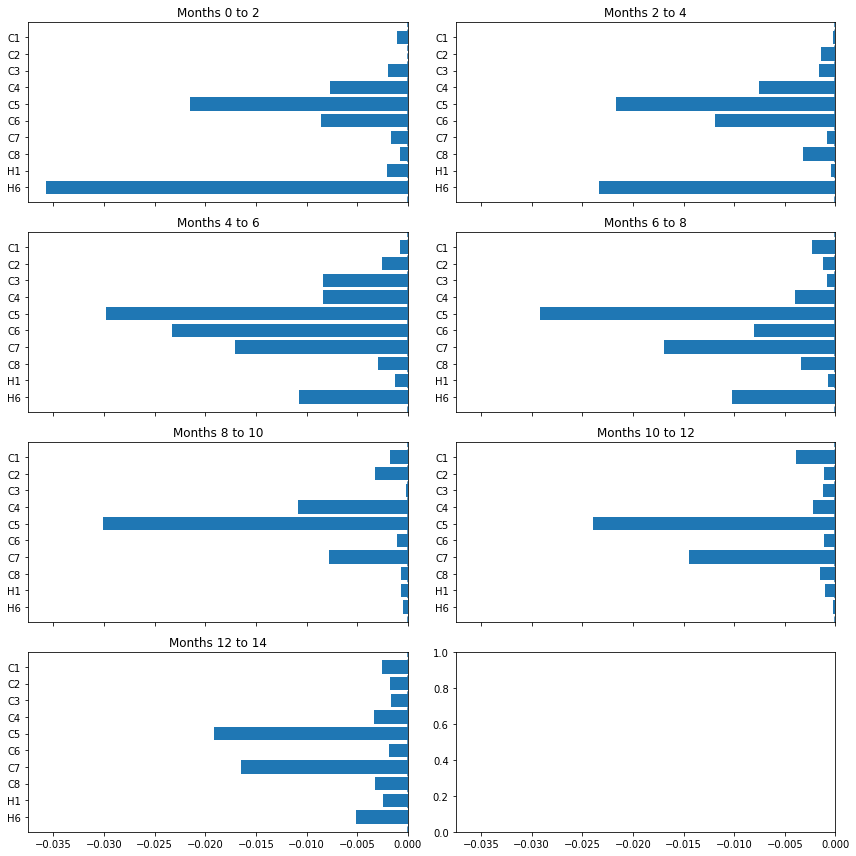

In [111]:
fig, axs = plt.subplots(nrows=coef_intv.shape[1]//2, ncols=2, sharex=True, figsize=(12, 12))
# don't use the last interval with less samples
for n, intv in enumerate(mu_coef_intv[:-1]):
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Months {} to {}'.format(n*2, (n+1)*2))
fig.tight_layout()

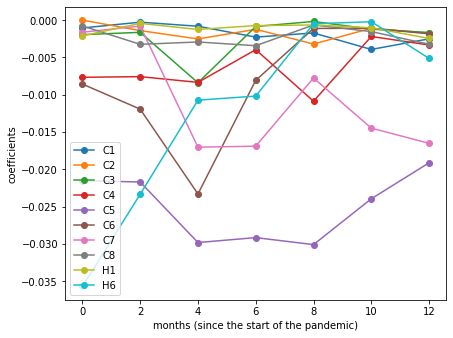

In [112]:
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, coef_intv.shape[1] * 2, 2), mu_coef_intv, 'o-')
plt.xlabel("months (since the start of the pandemic)")
plt.ylabel("coefficients")
plt.legend(chx_str)
plt.tight_layout()